In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
from dateutil.parser import parse

In [591]:
tickers = ['AAPL','MSFT']
start = '2006-01-01'
end = '2017-01-01'

def prices(tickers,start,end,backend='google'):
    if backend == 'quantopian':
        p = get_pricing(tickers,start,end)
        field = 'price'

    elif backend == 'google':
        p = web.DataReader(tickers, 'google', parse(start), parse(end))
        field = 'Close'
        
    return p,field

p,field = prices(tickers,start,end)

In [592]:
def calc_signals(tickers,p,a,b):
    sma = p[field].rolling(a).mean()
    smb = p[field].rolling(b).mean()
    signal = np.sign(sma - smb).diff()
    actual_signals = signal[signal!=0].dropna(how='all',axis=0)
    for col in actual_signals.columns:
        idx = actual_signals[col].first_valid_index()
        signal[col][idx] = signal[col][idx]/2

    return signal

sig = calc_signals(tickers,p,40,50)



In [593]:
def calc_pnl(sig,p):
    sig_up = sig.cumsum().apply(lambda x:x*(x>0))
    sig_dwn = sig.cumsum().apply(lambda x:x*(x<0))
    pnl = cumsum(p[field].diff()*sig_up-p[field].diff()*sig_dwn).sum(axis=1)
    return pnl

def calc_sharpe(sig,p):
    pnl = calc_pnl(sig,p)
    rets = diff(pnl)/pnl[:-1]
    rets = rets[~isinf(rets)]
    sharpe = np.nanmean(rets)/np.nanstd(rets)*sqrt(252)
    return sharpe
            
#print calc_pnl(sig,p)[-1]
#print calc_sharpe(sig,p)
#plot(calc_pnl(sig,p))
#show()

In [594]:
# parameter sweep
def parameter_sweep(tickers,p,params,N):
    pnls = []
    for i in range(N):
        a = min(params[i])
        b = max(params[i])
        try:
            sig = calc_signals(tickers,p,a,b)
            #pnls.append(calc_pnl(sig,p)[-1])
            pnls.append(calc_sharpe(sig,p))
        except:
            pnls.append(np.nan)
    return pnls


In [595]:
N = 1000
sm = 15
lm = 95
mid_point = '2011-01-01'
params = np.array([np.random.randint(60,90,(N,)) for i in range(2)]).T
p,field = prices(tickers,start,mid_point)
pnls1 = parameter_sweep(tickers,p,vals,N)
p,field = prices(tickers,mid_point,end)
pnls2 = parameter_sweep(tickers,p,vals,N)

print len(pnls1),len(pnls2)

1000 1000


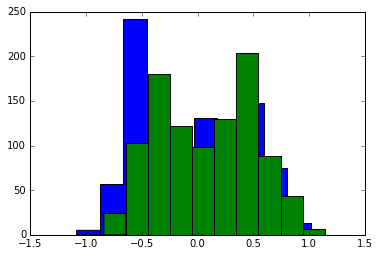

In [596]:
plt.hist(pnls1)
plt.hist(pnls2)
show()

In [597]:
def remove_nans(pnls1,pnls2,vals):
    idx1 = ~np.isnan(pnls1)
    pnls1 = np.array(pnls1)[idx1]
    pnls2 = np.array(pnls2)[idx1]
    vals = np.array(vals)[idx1]
    idx2 = ~np.isnan(pnls2)
    pnls1 = np.array(pnls1)[idx2]
    pnls2 = np.array(pnls2)[idx2]
    vals = np.array(vals)[idx2]
    return pnls1,pnls2,vals

In [598]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import calinski_harabaz_score



def get_cluster_number(X):
    score = 0 
    best_cluster_number = 0 
    for i in range(2,10):
        kmeans = AgglomerativeClustering(n_clusters = i)
        kmeans.fit(X)
        chs = calinski_harabaz_score(X,kmeans.labels_)
        if chs>score:
            best_cluster_number = i 
            score = chs 
    return best_cluster_number

pnls1,pnls2,params = remove_nans(pnls1,pnls2,params)
Nc = get_cluster_number(np.array([pnls1,pnls2]).T)
kmeans = KMeans(n_clusters=Nc).fit(np.array([pnls1,pnls2]).T)

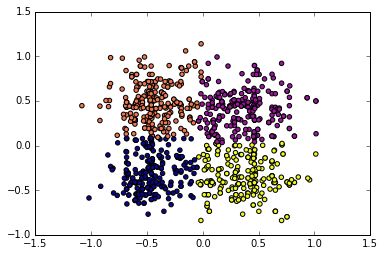

In [599]:
plt.scatter(pnls1,pnls2,c=kmeans.labels_,cmap='plasma')
show()

In [600]:
# Which cluster has the highest OOS pnl?

def find_best_cluster(kmeans):
    median_oos_pnl = []
    for label in np.unique(kmeans.labels_):
        median_pnl = median(pnls2[kmeans.labels_==label])
        median_oos_pnl.append(median_pnl)
    center_mean = argmax(mean(kmeans.cluster_centers_,axis=1))                         
    opt_label = argmax(median_oos_pnl)
    if center_mean!=opt_label:
        print 'Warning: best center mean is different from median oos pnl'
    return opt_label
    
opt_label = find_best_cluster(kmeans)

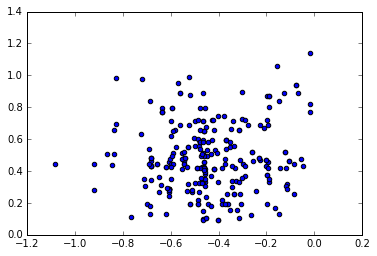

In [601]:
plt.scatter(pnls1[kmeans.labels_==opt_label],pnls2[kmeans.labels_==opt_label])
show()

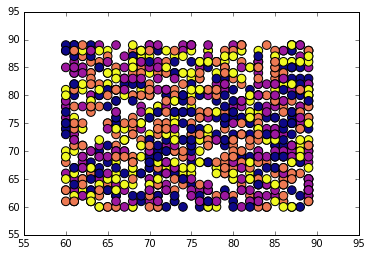

In [602]:
plt.scatter(np.array(params)[:,0],np.array(params)[:,1],c=kmeans.labels_,cmap='plasma',s=75)
show()

In [603]:
best_center = kmeans.cluster_centers_[opt_label]


In [604]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(3)
neigh.fit(np.array([pnls1,pnls2]).T,best_center)
dist,idx = neigh.kneighbors([best_center],15,return_distance=True)

In [605]:


# This is because we sometimes have larger and smaller lkbk reversed but sorted in the pnl calc, and we don't
# want to duplicate this.
unique_params = np.unique(map(sort,params[idx][0]),axis=0)
unique_params

array([[60, 84],
       [61, 89],
       [62, 67],
       [62, 71],
       [63, 88],
       [65, 82],
       [66, 81],
       [71, 75],
       [72, 83],
       [76, 83],
       [77, 81],
       [79, 84],
       [84, 86],
       [84, 89],
       [85, 86]])

102.85
103.97
104.7
103.2
105.68
105.96
105.96
103.61
104.25
103.33
103.77
101.64
103.88
103.75
103.57


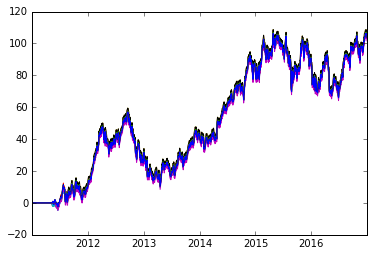

In [606]:
#calc_pnl(calc_signals(tickers,p,unique_params[idx][0][2][0],unique_params[idx][0][2][1]),p)
for par in unique_params:
    print (calc_pnl(calc_signals(tickers,p,par[0],par[1]),p))[-1]
    plot((calc_pnl(calc_signals(tickers,p,par[0],par[1]),p)))
show()